In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [4]:
trades = pd.read_csv("historical_data.csv")
sentiment = pd.read_csv("fear_greed_index.csv")

print(trades.shape)
print(sentiment.shape)


(130534, 16)
(2644, 4)


/tmp/ipython-input-4198877321.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  trades = pd.read_csv("historical_data.csv")


In [5]:
trades = trades.rename(columns={
    "Closed PnL": "closedPnL",
    "Size USD": "size_usd"
})


In [6]:
trades["Timestamp"] = pd.to_datetime(
    trades["Timestamp"],
    unit="ms",
    errors="coerce"
)

trades = trades.dropna(subset=["Timestamp"])
trades["date"] = trades["Timestamp"].dt.date

print("Unique trade dates:", trades["date"].nunique())


Unique trade dates: 7


In [7]:
daily_metrics = trades.groupby("date").agg(
    total_pnl=("closedPnL", "sum"),
    avg_pnl=("closedPnL", "mean"),
    total_volume_usd=("size_usd", "sum"),
    trades_count=("Account", "count")
).reset_index()

daily_metrics.shape


(7, 5)

In [8]:
sentiment["date"] = pd.to_datetime(sentiment["date"]).dt.date

sentiment["sentiment"] = sentiment["classification"].map({
    "Extreme Fear": 0,
    "Fear": 0,
    "Neutral": 0,
    "Greed": 1,
    "Extreme Greed": 1
})

sentiment["sentiment"].isna().sum()


np.int64(0)

In [9]:
merged = daily_metrics.merge(
    sentiment[["date", "sentiment"]],
    on="date",
    how="inner"
)

merged.shape


(6, 6)

In [10]:
!mkdir -p outputs
!mkdir -p csv_files


In [11]:
merged.to_csv("csv_files/merged_data.csv", index=False)


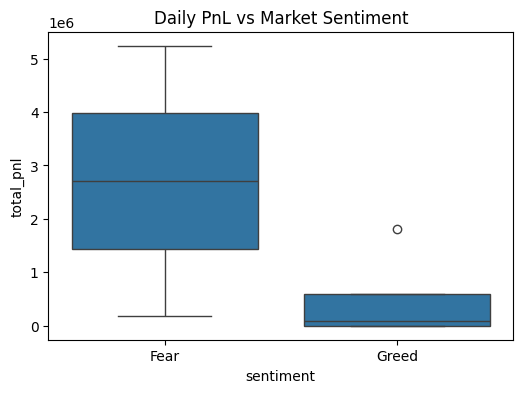

In [12]:
plt.figure(figsize=(6,4))
sns.boxplot(data=merged, x="sentiment", y="total_pnl")
plt.xticks([0,1], ["Fear", "Greed"])
plt.title("Daily PnL vs Market Sentiment")
plt.savefig("outputs/pnl_vs_sentiment.png")
plt.show()


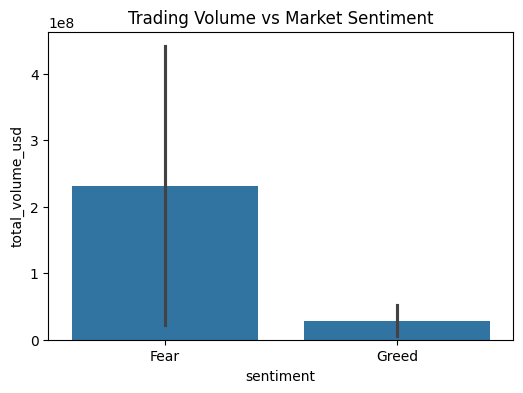

In [13]:
plt.figure(figsize=(6,4))
sns.barplot(data=merged, x="sentiment", y="total_volume_usd")
plt.xticks([0,1], ["Fear", "Greed"])
plt.title("Trading Volume vs Market Sentiment")
plt.savefig("outputs/volume_vs_sentiment.png")
plt.show()


In [14]:
print("FINAL MERGED SHAPE:", merged.shape)
merged


FINAL MERGED SHAPE: (6, 6)


,date,total_pnl,avg_pnl,total_volume_usd,trades_count,sentiment
0,2023-03-28,0.000000e+00,0.000000,4.770000e+02,3,1
1,2023-11-14,1.555034e+02,0.148807,1.155543e+07,1045,1
2,2024-03-09,1.769655e+05,25.418772,3.940677e+07,6962,1
3,2024-07-03,1.732489e+05,24.411566,2.150567e+07,7097,0
4,2024-10-27,1.818915e+06,100.692798,6.351263e+07,18064,1
5,2025-02-19,5.242402e+06,67.332866,4.408654e+08,77858,0


In [15]:
!zip -r outputs.zip outputs


  adding: outputs/ (stored 0%)
  adding: outputs/pnl_vs_sentiment.png (deflated 16%)
  adding: outputs/volume_vs_sentiment.png (deflated 16%)


In [16]:
!zip -r csv_files.zip csv_files


  adding: csv_files/ (stored 0%)
  adding: csv_files/merged_data.csv (deflated 40%)
